# Задание
1. Взять датасет https://www.kaggle.com/c/sberbank-russian-housing-market/overview
2. Провести EDA с упором на пропущенные значения
3. Обучить простую модель несколько раз (см. ниже) и сравнить качество.
4. При обучении модели постепенно заполнять пропуски. При заполнении пропусков обосновывать выбранный тип метода заполнения.
5. Сгенерировать не менее новых 5 признаков (генерация с помощью PolynomialFeatures считать как один признак) и обучить модель после каждого добавления нового признака для контроля качества.
6. Построить график изменения качества  модели на каждом шаге (после каждого заполнения пропусков в очередном признаке и после каждого добавления нового признака

In [55]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
df = pd.read_csv('train.csv')
df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,Investment,Otradnoe,1.005305e+07,175518,0.096270,0.300323,9753,5088.0,4,10311,12721.0,4,0,NaN,1,0,10,3,no,0,9,6,no,yes,no,yes,no,no,no,...,647.89,1112.68,880.28,8,20,30,15,5,1,0,5,12,1,0,29,3,15.52,17.24,44,838601,53,2548292,207,689.95,1156.08,923.02,18,63,59,47,15,5,0,15,26,1,2,84,6,7400000
30467,30470,2015-06

In [57]:
df.tail()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
30466,30469,2015-06-30,44,27.0,7.0,9.0,1.0,1975.0,2.0,6.0,3.0,Investment,Otradnoe,1.005305e+07,175518,0.096270,0.300323,9753,5088.0,4,10311,12721.0,4,0,NaN,1,0,10,3,no,0,9,6,no,yes,no,yes,no,no,no,...,647.89,1112.68,880.28,8,20,30,15,5,1,0,5,12,1,0,29,3,15.52,17.24,44,838601,53,2548292,207,689.95,1156.08,923.02,18,63,59,47,15,5,0,15,26,1,2,84,6,7400000
30467,30470,2015-06-30,86,59.0,3.0,9.0,2.0,1935.0,4.0,10.0,3.0,Investment,Tverskoe,7.307411e+06,75377,0.065444,0.000078,4237,1874.0,4,6398,6772.0,4,1,1046.0,3,2,29,16,yes,10,23,141,no,no,no,yes,yes,no,no,...,895.84,1476.65,1186.24,54,268,258,230,155,57,17,35,62,1,48,80,4,8.29,12.85,617,9949843,90,4345915,2197,887.43,1462.88,1175.16,136,550,535,511,313,128,24,98,182,1,82,171,15,25000000
30468,30471,2015-06-30,45,NaN,10.0,20.0,1.0,NaN,1.0,1.0,1.0,OwnerOccupier,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,275,NaN,0,264,NaN,0,0,NaN,0,0,0,0,no,0,1,0,no,no,no,no,no,no,no,...,700.00,1222.22,961.11,0,1,5,2,1,0,0,1,4,0,0,6,0,35.62,6.96,1,117300,4,201300,20,747.37,1263.16,1005.26,1,4,8,5,1,1,0,2,12,0,1,11,1,6970959
30469,30472,2015-06-30,64,32.0,5.0,15.0,1.0,2003.0,2.0,11.0,2.0,Investment,Obruchevskoe,6.050065e+06,78616,0.167526,0.093443,4215,2372.0,6,4635,6083.0,8,0,3300.0,2,1,11,1,no,0,4,5,no,no,no,yes,no,no,no,...,681.48,1152.78,917.13,7,32,37,26,13,0,0,2,17,1,2,33,4,30.36,9.33,39,1225712,45,1464521,230,703.20,1182.65,942.92,11,60,77,58,22,1,1,6,31,1,4,65,7,13500000
30470,30473,2015-06-30,43,28.0,1.0,9.0,1.0,1968.0,2.0,6.0,2.0,Investment,Novogireevo,4.395333e+06,94561,0.063755,0.038693,6120,2215.0,4,6533,5824.0,4,0,1015.0,2,0,7,1,no,0,5,1,no,no,no,yes,no,no,no,...,595.65,1054.35,825.00,1,13,24,6,2,1,0,3,7,0,7,26,4,25.10,10.16,15,351244,22,646575,93,664.44,1127.78,896.11,3,26,35,22,5,2,0,7,16,0,9,54,10,5600000


### Модель

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [59]:
def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

In [60]:
def get_boxplot(X, columns=[]):
  for i in columns:
    sns.boxplot(x=X[i])
  pass

In [61]:
def get_value(X, column, mode='mean', value=0, columns_for_reg=None):
  if mode == 'value':
    X.loc[X[X[column].isna()].index ,column] = value
  elif mode == 'max':
    X.loc[X[X[column].isna()].index ,column] = X[column].max()
  elif mode == 'min':
    X.loc[X[X[column].isna()].index ,column] = X[column].min()
  elif mode == 'median':
    X.loc[X[X[column].isna()].index ,column] = X[column].median()    
  elif mode == 'mode':
    X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]  
  elif mode == 'indicator':
    X.loc[X[X[column].isna()].index, column] = 0
    X['ind_'+str(column)] = 0
    X.loc[X[X[column].isna()].index, 'ind_'+str(column)] = 1
  elif mode == 'linreg':
    if columns_for_reg is None:
      cols = list(X.select_dtypes([np.number]).columns) 
      cols.remove(column)
    else:
      cols = columns_for_reg
    X_tmp = X.dropna()  
    m = LinearRegression().fit(X_tmp[cols], X_tmp[column])
    X.loc[X[X[column].isna()].index, column] = m.predict(X[X[column].isna()][cols])
  else:
    X.loc[X[X[column].isna()].index, column] = X[column].mean()
  return X

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Train примеры")
    plt.ylabel("Оценка")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Train score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="C-V score")

    plt.legend(loc="best")
    return plt

### EDA

Судя по прилагаемой документации, есть много неинформативных признаков, я просто запишу их в другую переменную, и в таргет запишем нужную для предсказания переменную

In [63]:
df.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,1.686600e+04,20899.000000,20899.000000,16912.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,23783.000000,30471.000000,30471.000000,23786.000000,30471.000000,30471.000000,16030.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,...,29480.000000,29480.000000,29480.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30293.000000,30471.000000,3.047100e+04,30471.000000,3.047100e+04,30471.000000,30174.000000,30174.000000,30174.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3.068057e+03,1.909804,6.399301,2.107025,1.765705e+07,84056.425552,0.218922,0.118871,5140.026156,3271.272464,4.065111,5354.269699,8324.970739,4.705031,0.109678,1190.738677,1.320895,0.138295,6.635030,2.896393,0.286732,4.200978,8.253454,1.463062e+05,67207.789603,79098.662105,11178.809491,5723.853106,5455.013948,53667.908897,27253.585803,26414.414821,19209.707164,5811.618162,...,765.900619,1283.334756,1024.617808,7.274622,27.782055,30.450297,26.685078,13.320108,4.646516,0.707131,6.122674,12.287979,0.199075,3.876440,20.239310,2.319944,22.769557,10.348669,71.356240,1.401057e+06,30.131863,1.173871e+06,265.528470,765.098467,1278.280635,1021.689513,17.806898,66.195530,73.442421,63.469660,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,1.543878e+05,0.851805,28.265979,0.880148,2.064961e+07,57871.285899,0.175090,0.118688,3816.625140,2169.759592,2.993795,3989.640917,4289.734174,3.445105,0.333328,1057.015001,1.492903,0.443796,6.571982,3.290058,1.510491,4.741812,23.536953,2.830251e+05,129444.557322,153630.894568,8287.957623,4275.438364,4020.546283,37483.559701,18939.154637,18643.132758,13174.721197,4073.828409,...,224.006719,353.299663,288.163451,18.242400,71.826492,69.528682,70.855732,41.282000,16.884524,2.775499,15.413697,25.785241,0.447815,13.188748,18.843867,2.271539,11.208471,5.668748,155.341362,2.3030

In [64]:
df = df.copy()

In [65]:
df = df[['timestamp','full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq',
'state','product_type', 'sub_area', 'area_m', 'raion_popul', 'green_zone_part', 'indust_part', 'preschool_education_centers_raion',
'school_education_centers_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'sport_objects_raion',
'additional_education_raion', 'shopping_centers_raion', 'office_raion', 'ID_metro', 'metro_min_walk', 'kindergarten_km',
'school_km', 'park_km', 'green_zone_km', 'industrial_km', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km',
'kremlin_km', 'ts_km', 'big_market_km','market_shop_km', 'fitness_km', 'university_km', 'workplaces_km', 'shopping_centers_km',
'office_km',  'additional_education_raion', 'preschool_km', 'price_doc']]

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   timestamp                          30471 non-null  object 
 1   full_sq                            30471 non-null  int64  
 2   life_sq                            24088 non-null  float64
 3   floor                              30304 non-null  float64
 4   max_floor                          20899 non-null  float64
 5   material                           20899 non-null  float64
 6   build_year                         16866 non-null  float64
 7   num_room                           20899 non-null  float64
 8   kitch_sq                           20899 non-null  float64
 9   state                              16912 non-null  float64
 10  product_type                       30471 non-null  object 
 11  sub_area                           30471 non-null  obj

Куча пропущенных значений

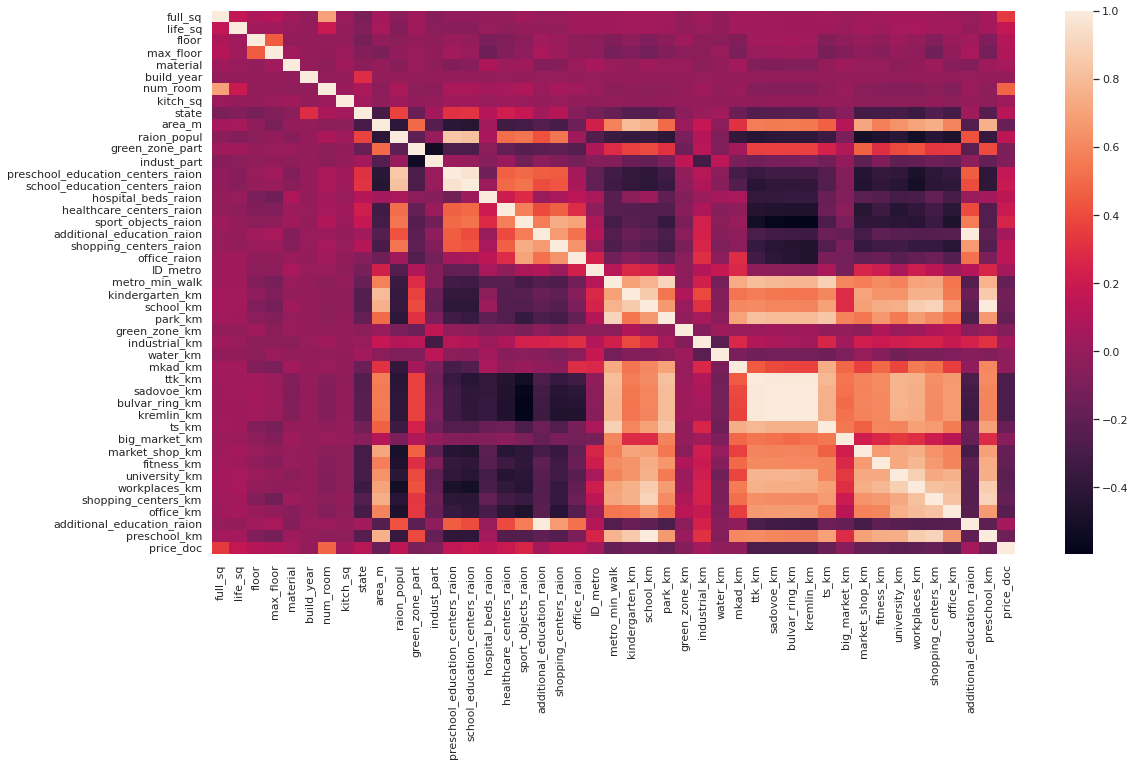

In [67]:
corr = df.corr()
plt.figure(figsize = (18, 10))
sns.heatmap(corr);

Распределение целевой переменной

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


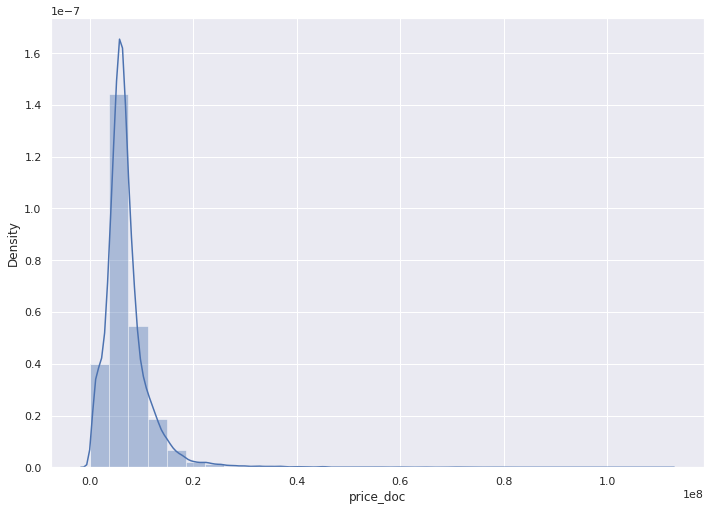

In [68]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['price_doc'], bins=30)
plt.show()

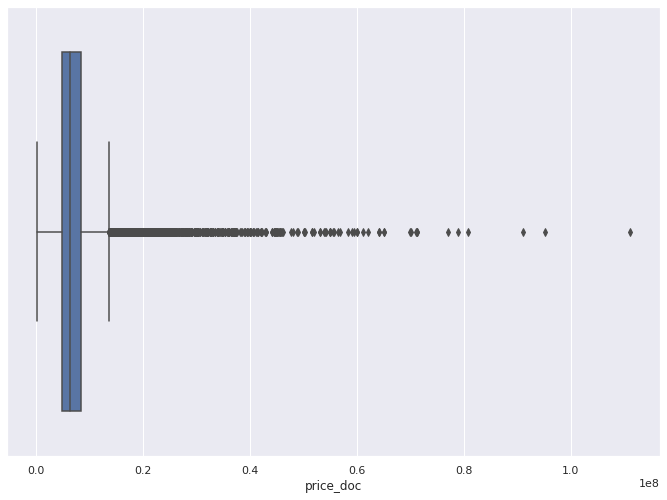

In [69]:
get_boxplot(df,['price_doc'])

Есть выбросы, рассмотрим их

In [70]:
df[df['price_doc'] > 70000000]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
2118,2012-05-10,55,31.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Teplyj Stan,8.392316e+06,130396,0.426396,0.002212,5,6,NaN,1,3,2,5,3,59,5.692791,0.134725,0.432346,0.680753,0.197776,1.881615,0.557242,1.040621,10.000894,12.645670,13.779558,14.547560,4.184125,4.043604,4.238845,0.989694,1.655190,2.757239,0.496593,1.239758,2,0.432346,111111112
3557,2012-09-10,157,89.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mar'ina Roshha,4.684028e+06,65972,0.015525,0.212515,1,1,628.0,3,7,4,7,16,124,11.417722,0.191674,1.072453,0.803618,0.344225,0.529682,0.361224,12.486303,0.741973,1.421816,1.998255,3.477546,1.853674,11.254245,1.064506,0.685544,0.551857,1.076010,0.887897,0.274919,4,1.072453,77000000
5728,2013-01-21,210,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Tverskoe,7.307411e+06,75377,0.065444,0.000078,4,4,1046.0,3,29,16,23,141,190,7.811982,0.109553,0.758281,0.463984,0.373498,1.323684,0.733344,13.970750,2.082063,0.153248,0.824967,2.245426,2.784583,10.858018,2.100574,0.468078,1.211506,1.302328,0.700109,0.042300,16,0.758281,71033632
6319,2013-03-06,206,128.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Pokrovskoe Streshnevo,1.308980e+07,53786,0.183969,0.150818,2,4,2643.0,4,10,2,5,4,64,38.052090,1.551464,0.741939,0.592933,0.063143,1.012213,0.180966,4.195866,7.926797,10.511390,11.304439,12.533137,2.695444,29.843020,3.221229,0.373393,4.851065,1.111248,0.790266,0.814473,2,0.741939,78802248
7457,2013-04-19,185,66.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Ramenki,1.880000e+07,125111,0.169625,0.019509,8,8,176.0,5,12,5,5,11,170,30.224681,0.543921,0.883583,1.768784,0.123274,0.858441,0.202902,6.685933,2.686379,5.397897,6.542679,7.424229,4.421095,16.176380,6.043965,0.104265,1.692878,3.237853,0.359529,0.413282,5,0.883583,91066096
11085,2013-10-08,132,76.0,16.0,28.0,4.0,2006.0,4.0,12.0,NaN,Investment,Prospekt Vernadskogo,4.695913e+06,61039,0.260460,0.000000,5,5,620.0,1,9,5,2,5,68,15.060547,0.482608,0.307083,0.790463,0.300011,2.282690,0.598425,4.231992,6.015150,8.696694,9.862957,10.685592,2.798006,7.923735,2.377491,0.307083,0.991514,4.116489,0.223131,0.613169,5,0.307083,71200000
19095,2014-05-29,184,85.0,10.0,47.0,4.0,2004.0,1.0,54.0,4.0,Investment,Ramenki,1.880000e+07,125111,0.169625,0.019509,8,8,176.0,5,12,5,5,11,170,30.224681,0.543921,0.883583,1.768784,0.123274,0.858441,0.202902,6.685933,2.686379,5.397897,6.542679,7.424229,4.421095,16.176380,6.043965,0.104265,1.692878,3.237853,0.359529,0.413282,5,0.883583,80777440
27460,2015-01-23,151,NaN,15.0,1.0,1.0,2015.0,4.0,1.0,1.0,OwnerOccupier,Ajeroport,4.662813e+06,73007,0.109947,0.050272,3,6,1020.0,0,4,3,3,14,153,16.089404,0.200208,0.456449,0.923174,0.133620,0.549325,2.827709,11.393209,0.242751,2.927125,3.658683,4.981078,3.927358,20.431540,2.937912,0.603068,2.547200,1.011697,0.568466,0.568466,3,0.456449,71249624
28326,2015-03-12,220,144.0,3.0,5.0,2.0,1927.0,9.0,17.0,3.0,Investment,Presnenskoe,1.163805e+07,123280,0.068202,0.042032,7,9,1940.0,2,29,2,5,84,184,13.808553,0.010781,0.345084,0.415343,0.208633,1.813986,0.452245,13.788497,3.131689,0.621388,0.209500,1.387915,4.068716,9.750911,3.010811,0.130117,0.988490,0.793147,0.832810,0.185520,2,0.345084,95122496


Странные значения, цена не соответсвуте району и жил.площади, можно их просто выкинуть

In [71]:
df = df.drop(df[df['price_doc'] > 70000000].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


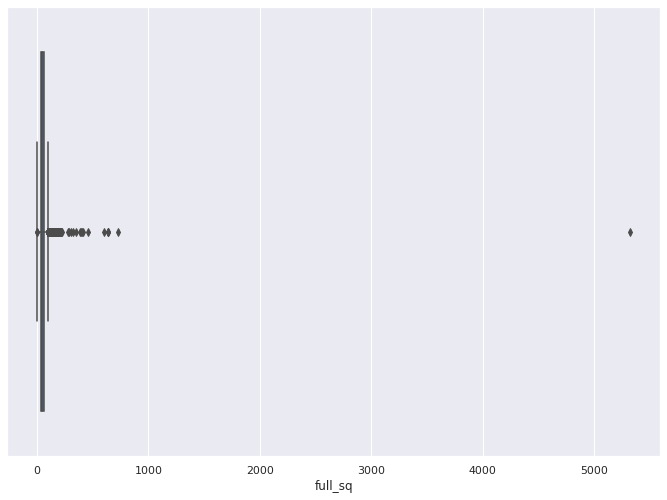

In [72]:
get_boxplot(df,['full_sq'])

In [73]:
df[df['full_sq'] > 4000]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
3527,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Birjulevo Vostochnoe,14795571.25,145088,0.308057,0.0509,6,6,30.0,2,8,3,3,1,30,28.439791,0.780191,0.699257,1.111874,0.499398,0.214503,0.703987,3.666678,10.84947,13.996607,15.623772,16.139809,1.927394,7.614379,3.169835,1.535936,7.517728,0.400044,1.89673,3.129234,3,0.699257,6868818


In [74]:
df = df.drop(df[df['full_sq'] > 4000].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


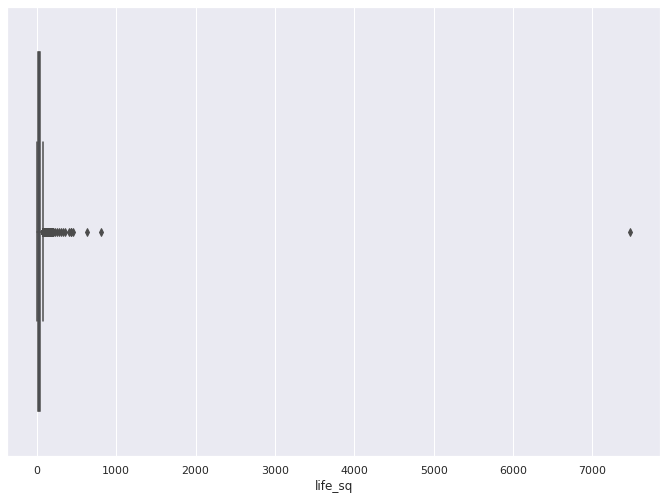

In [75]:
get_boxplot(df,['life_sq'])

In [76]:
df[df['life_sq'] > 7000]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
13546,2013-12-30,79,7478.0,8.0,17.0,1.0,2014.0,3.0,1.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,21494094.8,7122,0.262459,0.017647,0,0,NaN,0,0,2,0,0,45,27.058996,0.647239,0.826052,1.799915,0.314382,1.006133,0.138168,7.229763,20.483476,23.613614,24.89313,25.595974,9.53014,14.703756,6.287163,0.680017,18.733878,8.802153,3.231528,5.072389,2,0.826052,7705000


In [77]:
df = df.drop(df[df['life_sq'] > 7000].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


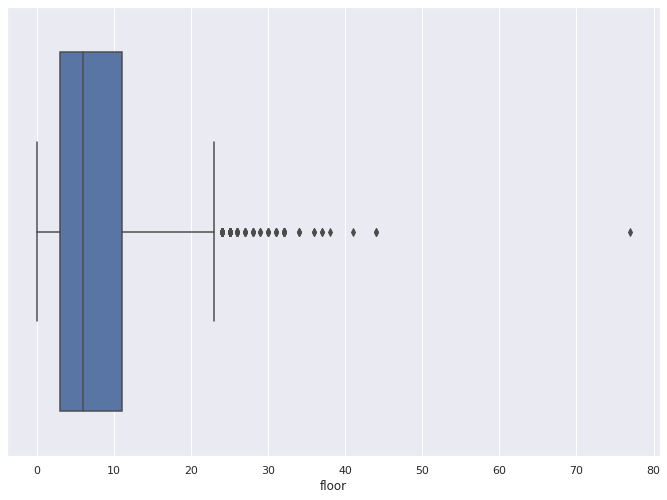

In [78]:
get_boxplot(df,['floor'])

In [79]:
df[df['floor'] > 70]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
23584,2014-10-15,57,33.0,77.0,22.0,1.0,1986.0,2.0,10.0,3.0,Investment,Lomonosovskoe,3326418.741,83844,0.051881,0.0,5,7,46.0,1,6,4,1,4,68,23.624139,0.171341,0.38909,0.86354,0.223338,1.004353,0.345965,5.811956,5.191263,7.989246,9.101984,9.851504,5.093557,6.221886,3.268157,0.489492,2.655779,2.848309,0.749363,0.310557,4,0.489763,13700000


In [80]:
df = df.drop(df[df['floor'] > 70].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


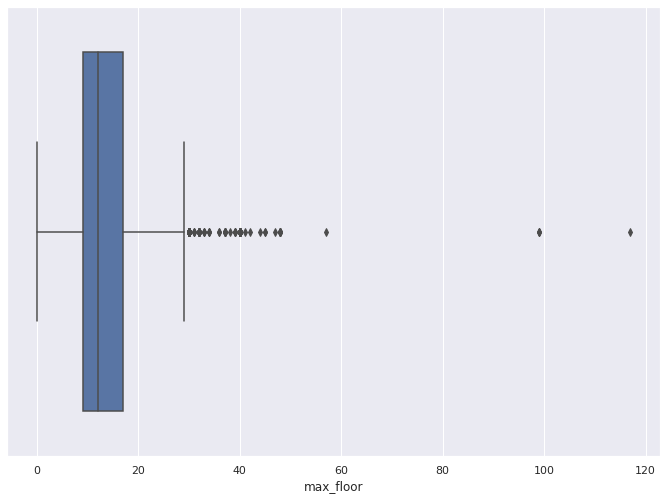

In [81]:
get_boxplot(df,['max_floor'])

In [82]:
df[df['max_floor'] > 80]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
20722,2014-07-10,47,47.0,4.0,99.0,2.0,NaN,1.0,1.0,NaN,OwnerOccupier,Pokrovskoe Streshnevo,1.308980e+07,53786,0.183969,0.150818,2,4,2643.0,4,10,2,5,4,64,30.038328,1.005061,0.331429,1.624049,0.699127,0.000000,0.483653,3.130875,8.986495,11.615936,12.415392,13.637751,1.576380,24.391233,0.839514,0.514682,5.375113,0.340327,0.511089,0.511089,2,0.331429,10238400
21734,2014-08-21,71,71.0,5.0,99.0,6.0,NaN,2.0,9.0,NaN,OwnerOccupier,Poselenie Moskovskij,4.036700e+07,21819,0.492840,0.075779,0,0,NaN,0,3,3,2,3,140,21.368381,1.075395,1.690124,2.166759,0.294153,0.437857,0.191540,0.718060,11.058260,13.752727,14.921602,15.750244,1.667530,8.281028,1.948185,0.844727,5.842595,5.247596,0.742543,0.743497,3,1.690124,8484365
21852,2014-08-25,46,46.0,17.0,99.0,6.0,NaN,3.0,9.0,NaN,OwnerOccupier,Poselenie Sosenskoe,6.677245e+07,9553,0.336177,0.072158,0,0,NaN,0,1,0,0,1,45,70.262575,3.122004,3.382934,4.746198,0.595237,0.086297,0.183995,3.857302,17.020297,19.997325,21.175744,21.906560,5.426349,4.792372,6.922646,0.442563,9.451180,6.354706,4.502560,4.091140,0,3.382934,6670000
25940,2014-12-06,63,63.0,8.0,117.0,1.0,NaN,2.0,1.0,1.0,OwnerOccupier,Tverskoe,7.307411e+06,75377,0.065444,0.000078,4,4,1046.0,3,29,16,23,141,120,13.459068,1.048962,0.269716,0.284300,0.189089,2.640803,0.524839,13.917815,4.081283,2.185333,0.506919,0.072897,3.757130,7.836658,1.092897,0.269716,2.180440,1.091507,0.107360,0.182194,16,0.269716,7239838


In [83]:
df = df.drop(df[df['max_floor'] > 80].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


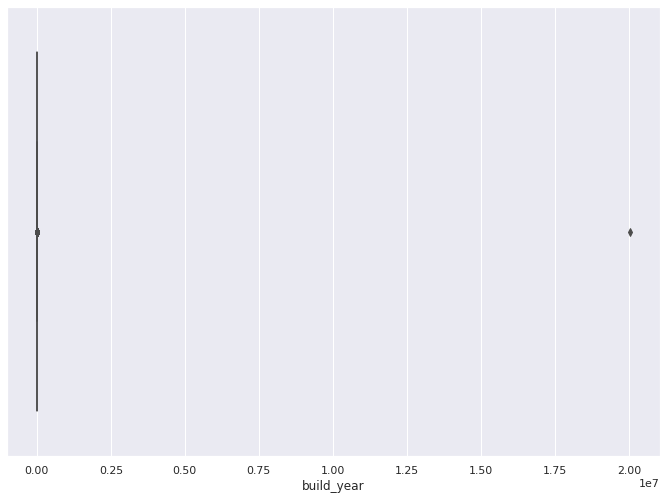

In [84]:
get_boxplot(df,['build_year'])

In [85]:
df[df['build_year'] > 20000]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
10089,2013-08-27,37,16.0,8.0,12.0,1.0,20052009.0,1.0,9.0,33.0,Investment,Cheremushki,5467178.309,102618,0.055779,0.13633,4,5,262.0,3,6,4,6,10,111,9.174529,0.283316,0.176377,1.394512,0.276778,1.381036,0.7313,7.605656,3.996145,6.962958,8.161898,8.883625,3.694416,5.993103,2.794578,0.262379,1.289754,1.48208,0.700188,0.250911,4,0.744923,9000000


In [86]:
df = df.drop(df[df['build_year'] > 20000].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


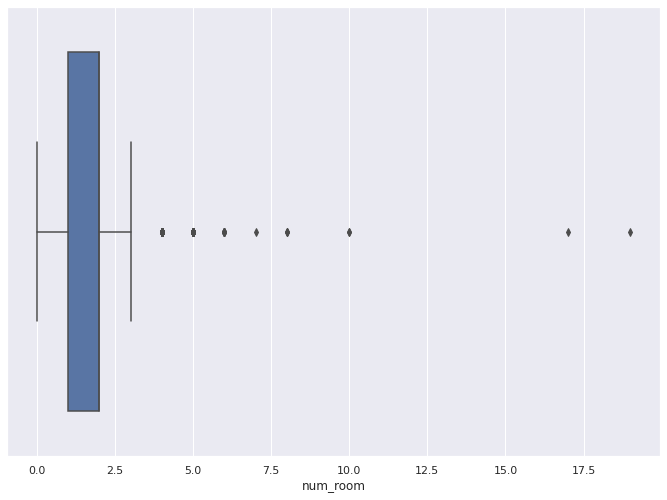

In [87]:
get_boxplot(df, ['num_room'])

In [88]:
df[df['num_room'] > 15]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
11621,2013-10-28,40,19.0,17.0,17.0,1.0,2011.0,19.0,7.0,3.0,Investment,Poselenie Vnukovskoe,2.553630e+07,4001,0.496315,0.007122,0,0,NaN,0,0,0,1,0,21,53.937418,1.551697,1.063754,6.778371,0.346562,1.854658,0.197859,9.35164,19.333081,22.053826,23.221195,24.093342,5.908985,17.652473,9.188754,3.752107,15.000129,11.269663,0.412866,4.581006,0,1.063754,2630000
26713,2014-12-18,51,30.0,14.0,17.0,1.0,1984.0,17.0,8.0,3.0,Investment,Obruchevskoe,6.050065e+06,78616,0.167526,0.093443,6,8,3300.0,2,11,1,4,5,83,21.544815,0.663373,0.129363,0.640720,0.042211,0.346409,0.174243,5.38344,5.886876,8.815469,9.906834,10.651391,4.391505,4.891840,2.047915,0.218618,2.965958,3.572781,0.687470,0.341297,1,0.129363,13150000


Подозрительные признаки с маленькой площадью и большим количеством комнат

In [89]:
df = df.drop(df[df['num_room'] > 15].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


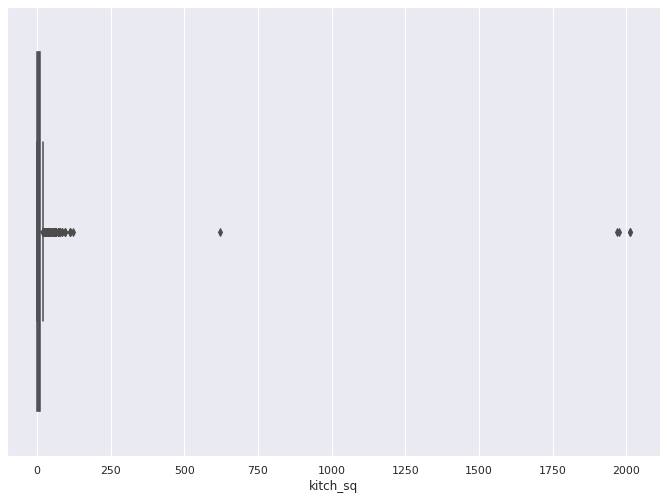

In [90]:
get_boxplot(df,['kitch_sq'])

In [91]:
df[df['kitch_sq'] > 1800]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
10368,2013-09-10,79,41.0,5.0,17.0,6.0,2013.0,3.0,2013.0,1.0,OwnerOccupier,Poselenie Voskresenskoe,21494094.80,7122,0.262459,0.017647,0,0,NaN,0,0,2,0,0,45,29.242588,0.745286,0.936324,1.773759,0.456704,1.018137,0.006707,7.371716,20.624073,23.753388,25.032110,25.735256,9.658805,14.350258,6.469129,0.822324,18.915844,8.941513,3.172334,5.087106,2,0.936324,7281225
13117,2013-12-14,31,19.0,5.0,1.0,1.0,NaN,1.0,1970.0,3.0,Investment,Izmajlovo,15045565.20,102828,0.637399,0.006076,4,6,645.0,6,16,3,6,0,76,17.805130,0.651020,0.624749,2.238930,0.100984,0.126751,0.390672,6.072456,3.451654,5.746990,6.480431,8.220659,4.774844,13.536643,3.069829,1.008082,1.498504,1.290812,0.034804,0.551638,3,0.624749,3650000
21415,2014-08-11,43,43.0,3.0,1.0,1.0,2014.0,1.0,2014.0,1.0,OwnerOccupier,Poselenie Sosenskoe,66772450.69,9553,0.336177,0.072158,0,0,NaN,0,1,0,0,1,132,73.662835,3.803968,3.840841,4.194698,0.490269,0.120089,0.534080,3.444627,16.498102,19.461901,20.618643,21.353767,4.881722,4.019261,6.149534,0.395077,8.678068,5.873590,4.255828,3.309481,0,3.840841,3801200
28734,2015-03-31,31,16.0,2.0,12.0,5.0,1972.0,1.0,1974.0,3.0,Investment,Matushkino,4708040.47,38075,0.271702,0.310199,3,4,NaN,0,0,0,0,1,12,297.044946,1.865702,0.645011,17.352953,0.016858,0.290751,0.141561,20.174858,33.523265,36.263747,36.995374,38.311910,21.017186,39.033842,3.242406,2.360463,4.092086,1.234051,2.272021,1.470927,0,0.645011,1000000


Возможно, это какие то заведения, пока  оставим

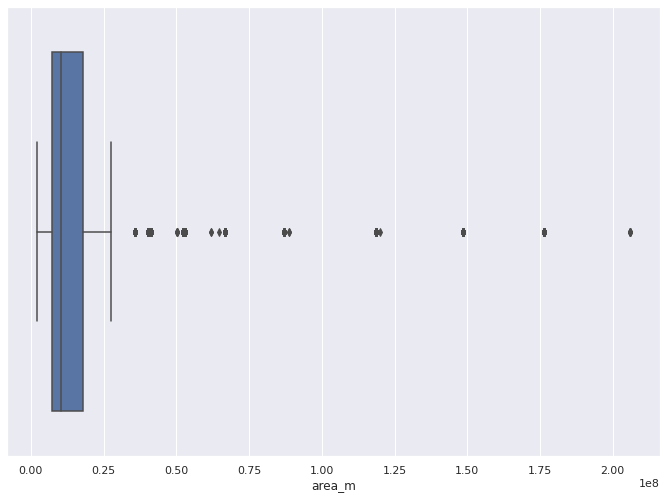

In [92]:
get_boxplot(df,['area_m'])

In [93]:
df[df['area_m'] > 2.00e+08]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
7717,2013-04-30,112,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OwnerOccupier,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,110,504.235505,10.000361,31.615851,31.349617,0.098173,1.236465,0.349650,37.830521,50.884823,53.844547,54.941560,55.686785,39.309703,42.374704,24.647701,19.773218,47.033512,40.105197,23.697360,5.589087,0,31.615851,4794000
10761,2013-09-26,35,18.0,3.0,5.0,1.0,2007.0,1.0,8.0,3.0,Investment,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,45,479.739711,11.892630,32.070718,32.010391,0.244764,0.047997,0.415879,38.078688,50.994194,53.894699,55.009260,55.757801,39.491955,39.170183,21.443180,19.571648,43.828991,40.210220,24.876814,4.845655,0,32.070718,3100000
14435,2014-01-31,63,63.0,11.0,17.0,1.0,2014.0,2.0,1.0,1.0,OwnerOccupier,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,45,481.497742,13.241818,29.693427,29.985754,0.198144,1.469643,0.504154,35.306528,47.973603,50.784699,51.916794,52.671230,36.131719,39.316686,21.589682,16.396836,43.975494,37.231630,23.976692,8.439121,0,29.693427,6093691
14769,2014-02-10,42,20.0,13.0,14.0,6.0,2012.0,1.0,10.0,3.0,Investment,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,110,512.456771,10.566591,31.355867,31.191677,0.043816,0.297664,0.058489,37.476284,50.470652,53.404576,54.509490,55.256362,38.924897,41.896605,24.169602,19.202589,46.555413,39.685523,23.813111,5.570553,0,31.355867,2400000
21033,2014-07-23,44,27.0,2.0,5.0,1.0,1972.0,2.0,5.0,2.0,Investment,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,110,490.986505,9.709389,32.024149,31.670508,0.015050,0.763088,0.441879,38.313098,51.412246,54.372043,55.482680,56.226337,39.817513,43.236127,25.509123,20.448982,68.501311,40.497928,23.785350,5.651928,0,32.024149,3250000
21343,2014-08-07,39,16.0,1.0,5.0,1.0,1994.0,1.0,8.0,4.0,Investment,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,110,505.848712,10.100365,31.560055,31.313376,0.299133,1.030281,0.437718,37.757260,50.800591,53.755770,54.854027,55.599587,39.230590,42.273419,24.546415,19.656931,46.932226,40.019473,23.713013,5.570773,0,31.560055,3600000
28258,2015-03-07,41,NaN,1.0,1.0,1.0,NaN,1.0,1.0,NaN,OwnerOccupier,Poselenie Voronovskoe,206071809.2,8227,0.641939,0.01132,0,0,NaN,0,0,0,0,1,45,522.548610,15.643328,34.048105,34.275450,0.476685,2.003031,0.244817,39.691265,52.340739,55.137857,56.271387,57.027714,40.390032,42.737592,25.010588,20.767492,47.396399,41.606697,22.681465,5.034799,0,34.048105,2460405


In [94]:
df = df.drop(df[df['area_m'] > 2.00e+08].index)
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


## Пропущенные значения

Смотрим значения nan

In [95]:
missing_value = df.columns[df.isnull().any()].tolist()

pd.isnull(df[missing_value]).sum().sort_values(ascending=True) / len (df)

metro_min_walk         0.000821
floor                  0.005452
life_sq                0.209558
max_floor              0.314173
material               0.314173
num_room               0.314173
kitch_sq               0.314173
state                  0.444966
build_year             0.446477
hospital_beds_raion    0.473937
dtype: float64

In [96]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [97]:
_ = get_value(df, 'metro_min_walk', mode = 'median', value = 0, columns_for_reg=['office_raion','ID_metro','kindergarten_km'])
df.head()           

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [98]:
_ = get_value(df, 'floor', mode = 'moda', value = 0, columns_for_reg=['full_sq','life_sq'])
df.head()               

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [99]:
_ = get_value(df, 'life_sq', mode = 'median', value = 0, columns_for_reg=['area_m','raion_popul','green_zone_part','indust_part'])
df.head()               

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [100]:
_ = get_value(df, 'max_floor', mode = 'mode', value = 0, columns_for_reg=['full_sq','life_sq','floor'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [101]:
_ = get_value(df, 'material', mode = 'mode', value = 0, columns_for_reg=['full_sq',	'life_sq',	'floor'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [102]:
_ = get_value(df, 'num_room', mode = 'mode', value = 0, columns_for_reg=['full_sq','life_sq','floor'])
df.head()   

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,NaN,2.0,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,NaN,2.0,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,NaN,2.0,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,NaN,2.0,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,NaN,2.0,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [103]:
_ = get_value(df, 'kitch_sq', mode = 'median', value = 0, columns_for_reg=['area_m','raion_popul','green_zone_part'])      
df.head()               

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,NaN,2.0,6.0,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,NaN,2.0,6.0,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,NaN,2.0,6.0,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,NaN,2.0,6.0,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,NaN,2.0,6.0,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [104]:
_ = get_value(df, 'state', mode = 'median', value = 0, columns_for_reg=['area_m','raion_popul','green_zone_part'])      
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,NaN,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,NaN,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,NaN,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,NaN,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,NaN,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [105]:
_ = get_value(df, 'build_year', mode = 'mode', value = 0, columns_for_reg=['full_sq', 'life_sq','floor'])      
df.head()       

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,NaN,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [106]:
_ = get_value(df, 'hospital_beds_raion', mode = 'mode', value = 0, columns_for_reg=['healthcare_centers_raion',	'sport_objects_raion',	'additional_education_raion',	'shopping_centers_raion'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [107]:
_ = get_value(df, 'preschool_km', mode = 'mode', value = 0, columns_for_reg=['additional_education_raion',	'office_km',	'shopping_centers_km',	'shopping_centers_raion'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [108]:
_ = get_value(df, 'price_doc', mode = 'mode', value = 0, columns_for_reg=['preschool_km',	'additional_education_raion',	'office_km',	'shopping_centers_km'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452


In [109]:
pd.isnull(df[missing_value]).sum().sort_values(ascending=True) / len (df)

life_sq                0.0
floor                  0.0
max_floor              0.0
material               0.0
build_year             0.0
num_room               0.0
kitch_sq               0.0
state                  0.0
hospital_beds_raion    0.0
metro_min_walk         0.0
dtype: float64

## Преобразование 

In [110]:
df['timestamp_'] = (pd.to_datetime('2011-08-20')).strftime('%s')
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc,timestamp_
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000,1313798400
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000,1313798400
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000,1313798400
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000,1313798400
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452,1313798400


In [111]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['product_type_'] = le.fit_transform(df['product_type'])
df['sub_area_'] = le.fit_transform(df['sub_area'])
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,price_doc,timestamp_,product_type_,sub_area_
0,2011-08-20,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,5850000,1313798400,0,9
1,2011-08-23,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,6000000,1313798400,0,70
2,2011-08-27,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,5700000,1313798400,0,128
3,2011-09-01,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,13100000,1313798400,0,65
4,2011-09-05,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,16331452,1313798400,0,6


In [112]:
target = df['price_doc']
df = df.drop(['timestamp','product_type', 'sub_area', 'price_doc'], axis = 1)
df.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,preschool_education_centers_raion,school_education_centers_raion,hospital_beds_raion,healthcare_centers_raion,sport_objects_raion,additional_education_raion,shopping_centers_raion,office_raion,ID_metro,metro_min_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,ts_km,big_market_km,market_shop_km,fitness_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_raion,preschool_km,timestamp_,product_type_,sub_area_
0,43,27.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,6.407578e+06,155572,0.189727,0.000070,5,5,240.0,1,7,3,16,1,1,13.575119,0.145700,0.177975,2.158587,0.600973,1.080934,0.992631,1.422391,10.918587,13.100618,13.675657,15.156211,4.308127,10.814172,1.676258,0.485841,6.715026,0.884350,0.648488,0.637189,3,0.177975,1313798400,0,9
1,34,19.0,3.0,17.0,1.0,2014.0,2.0,6.0,2.0,9.589337e+06,115352,0.372602,0.049637,5,8,229.0,1,6,1,3,0,2,7.620630,0.147754,0.273345,0.550690,0.065321,0.966479,0.698081,9.503405,3.103996,6.444333,8.132640,8.698054,0.725560,6.910568,3.424716,0.668364,1.852560,0.686252,0.519311,0.688796,1,0.273345,1313798400,0,70
2,43,29.0,2.0,17.0,1.0,2014.0,2.0,6.0,2.0,4.808270e+06,101708,0.112560,0.118537,4,7,1183.0,1,5,1,0,1,3,17.351515,0.049102,0.158072,0.374848,0.453172,0.939275,0.468265,5.604800,2.927487,6.963403,8.054252,9.067885,3.562188,5.752368,1.375443,0.733101,0.841254,1.510089,1.486533,1.543049,1,0.158072,1313798400,0,128
3,89,50.0,9.0,17.0,1.0,2014.0,2.0,6.0,2.0,1.258354e+07,178473,0.194703,0.069753,9,10,540.0,1,17,6,11,4,4,11.565624,0.179441,0.236455,0.078090,0.106125,0.451173,1.200336,2.677824,14.606501,17.457198,18.309433,19.487005,0.583025,27.892717,0.811275,0.623484,10.903161,0.622272,0.599914,0.934273,6,0.236455,1313798400,0,65
4,77,77.0,4.0,17.0,1.0,2014.0,2.0,6.0,2.0,8.398461e+06,108171,0.015234,0.037316,7,9,562.0,4,25,2,10,93,5,8.266305,0.247901,0.376838,0.258289,0.236214,0.392871,0.820294,11.616653,1.721834,0.046810,0.787593,2.578671,2.609420,9.155057,1.969738,0.220288,0.991683,0.892668,0.429052,0.077901,2,0.376838,1313798400,0,6


In [113]:
get_score(df, target)

0.4866094977460429